In [209]:
import pandas as pd
import numpy as np
import missingno as msno
from scipy.stats import chi2_contingency
import matplotlib.gridspec as gridspec
from statsmodels.graphics.mosaicplot import mosaic

import seaborn as sns
from scipy.stats import chi2_contingency
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sagemaker import get_execution_role

pd.set_option('display.max_columns', None)

role=get_execution_role()
data_location = 's3://20172337project/20172337/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df=pd.read_csv(data_location)

In [210]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


SeniorCitizen타입을 object로 변환
TotalCharges에 빈 문자열이 있기 때문에 수치형으로 변환하면 에러나나서 errors = "coerce"를 추가하여 결측치로 바꿈

In [212]:
df["SeniorCitizen"] = df["SeniorCitizen"].astype("object")
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors = "coerce")

In [213]:
df.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


수치형 변수들의 데이터 분포를 확인

array([[<AxesSubplot:title={'center':'tenure'}>,
        <AxesSubplot:title={'center':'MonthlyCharges'}>],
       [<AxesSubplot:title={'center':'TotalCharges'}>, <AxesSubplot:>]],
      dtype=object)

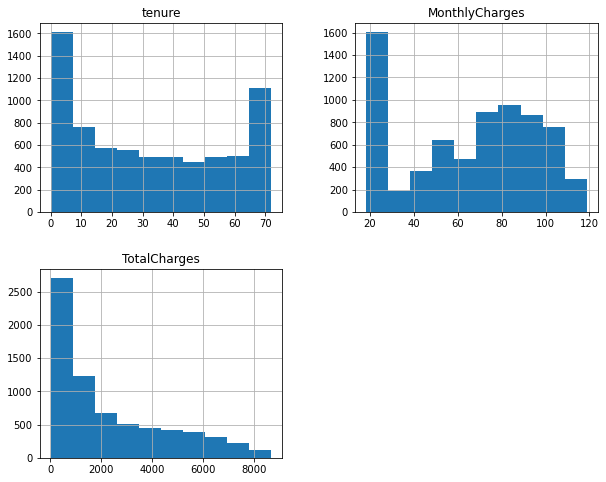

In [214]:
df.hist(figsize = (10, 8), bins = 10)

각각의 X축들의 스케일이 다름. TotalCharges변수와 같이 꼬리가 두꺼우면 머신러닝 알고리즘은 패턴을 더욱 쉽게 찾을 수 있음. 데이터 분포를 정규분포나 가우시안 분포를 따르도록 변형하는 것이 좋아보임.

<AxesSubplot:>

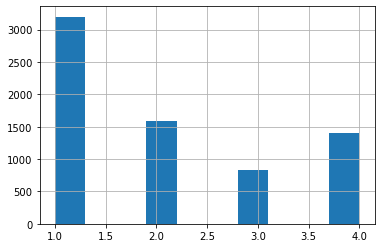

In [215]:
df = df[df["tenure"]!=0].reset_index(drop=True)
df.shape
df["tenure_cat"] = pd.cut(df["tenure"], bins = [0,24,48,60,72], labels = [1,2,3,4])
df["tenure_cat"].hist()

tenure 변수에 0의 값을 가지는 경우가 11건이 존재한다. 이는 계약한지 1달도 안된 신규 고객이므로 샘플링에서 제외.

In [216]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 20171490)

for train_index, test_index in split.split(df, df["tenure_cat"]):
    X_train = df.loc[train_index]
    X_test = df.loc[test_index]

* 구체적으로 살펴보기 전에 먼저 테스트 데이터를 따로 생성(테스트 데이터를 전체 데이터의 20% 정도로 사용)
* 중요 변수인 고객이 회사와 계약해 온 기간을 계층적으로 계층적 샘플링을 하여 테스트 데이터를 생성
* 고객과 계약해 온 기간(tenure_cat)을 기반으로 StratifiedShffuleSplit을 이용하여 계층적 샘플링 진행

In [217]:
X_train["tenure_cat"].value_counts()/len(X_train)

1    0.454933
2    0.226667
4    0.200000
3    0.118400
Name: tenure_cat, dtype: float64

In [218]:
X_test["tenure_cat"].value_counts()/len(X_test)

1    0.454869
2    0.226724
4    0.200426
3    0.117982
Name: tenure_cat, dtype: float64

샘플링 한 후 각 계층별로 샘플 수가 비슷하게 추출되었는지 확인

In [219]:
for set_ in (X_train, X_test):
    set_.drop("tenure_cat",axis = 1, inplace = True)

비슷한 비율로 샘플린 되어서 이 카테고리 화한 변수 제거

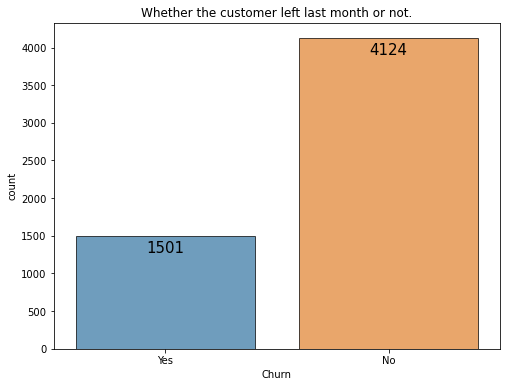

In [220]:
data = X_train.copy()

plt.figure(figsize = (8,6))
splot = sns.countplot(data["Churn"], edgecolor="black",alpha=0.7)  # alpha를 이용하여 색 조정 
plt.title("Whether the customer left last month or not.")


for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')

훈련 데이터를 손상시키지 않기 위해 복사본을 만들고 데이터 클래스 분포를 확인

Whether the customer left last month or not(지난 달에 고객 이탈 유무)

지난달에 떠난 고객보다 떠나지 않은 고객이 더 많음

In [221]:
df = df.drop("customerID",axis = 1)

In [222]:
for column in df.columns:
    if df[column].dtypes==object:
        print(str(column)+ ' : '+ str(df[column].unique()))
        print (df[column].value_counts())
        print('------------------------------')

gender : ['Female' 'Male']
Male      3549
Female    3483
Name: gender, dtype: int64
------------------------------
SeniorCitizen : [0 1]
0    5890
1    1142
Name: SeniorCitizen, dtype: int64
------------------------------
Partner : ['Yes' 'No']
No     3639
Yes    3393
Name: Partner, dtype: int64
------------------------------
Dependents : ['No' 'Yes']
No     4933
Yes    2099
Name: Dependents, dtype: int64
------------------------------
PhoneService : ['No' 'Yes']
Yes    6352
No      680
Name: PhoneService, dtype: int64
------------------------------
MultipleLines : ['No phone service' 'No' 'Yes']
No                  3385
Yes                 2967
No phone service     680
Name: MultipleLines, dtype: int64
------------------------------
InternetService : ['DSL' 'Fiber optic' 'No']
Fiber optic    3096
DSL            2416
No             1520
Name: InternetService, dtype: int64
------------------------------
OnlineSecurity : ['No' 'Yes' 'No internet service']
No                     3497
Yes 

범주형 변수들의 값들 확인

In [223]:
category_features = []

for column in df.columns:
    if df[column].dtypes==object:
        category_features.append(column)

In [224]:
print(len(category_features))
category_features.remove("Churn")
print(category_features)
print(len(category_features))

17
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
16


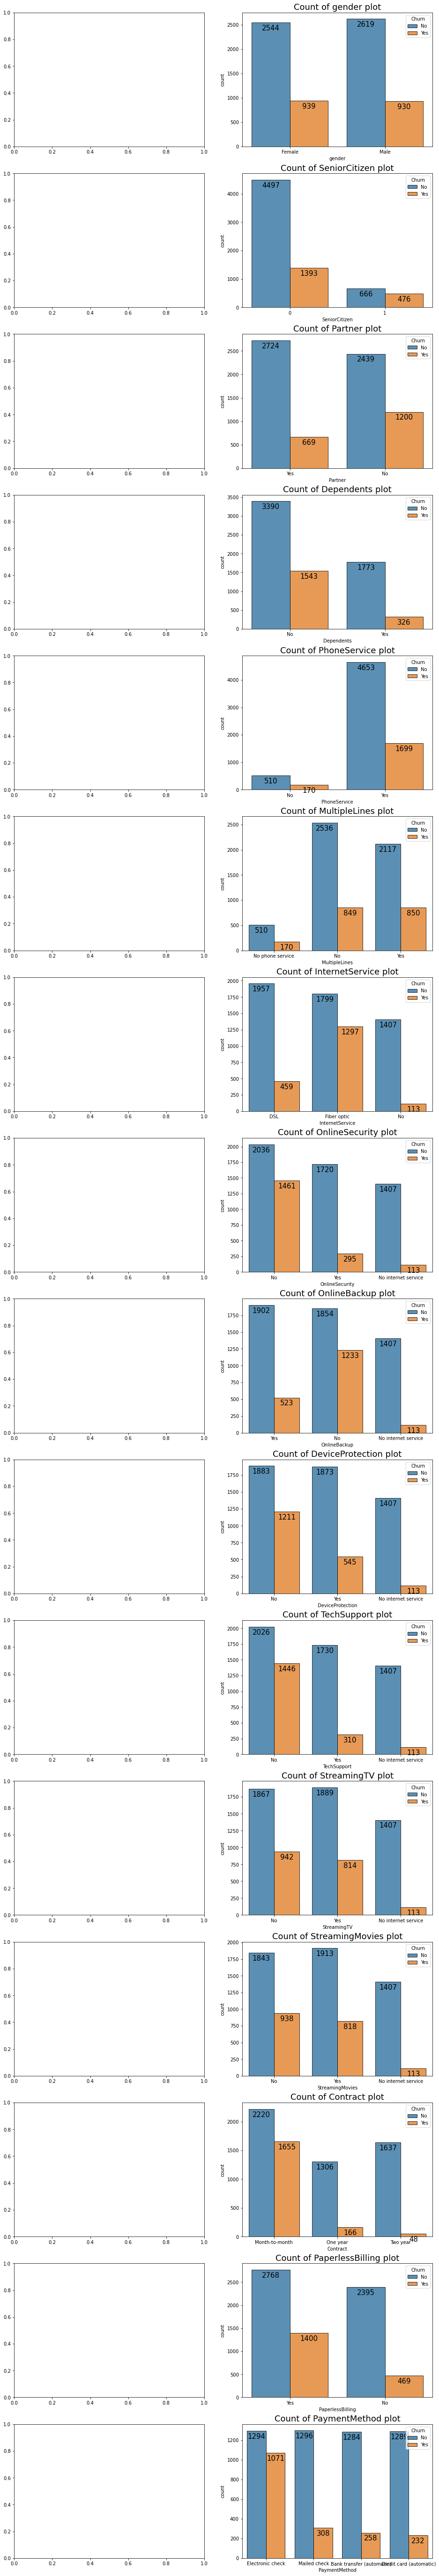

In [225]:
f, ax = plt.subplots(16,2,figsize=[16,100])

for i, cn in enumerate(df[category_features]):
    
    splot = sns.countplot(df[cn],data = df,hue = "Churn", edgecolor="black",alpha=0.8,ax = ax[i, 1])
    ax[i,1].set_title("Count of "+cn+" plot", fontsize = 18)
    
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.0f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       size=15,
                       xytext = (0, -12), 
                       textcoords = 'offset points')

plt.show()

### 컬럼별로 나눠봤을 때 전체적으로 떠나지 않은 고객이 이탈 고객보다 더 많음.

* 성별에 따라서 크게 차이가 없음.
* 고령자가 아닌 고객이 고령자인 고객보다 더 많고 이탈하는 고객과 이탈하지 않는 고객 모두 고령자인 고객에 비해 많음.
* 파트너가 없는 고객의 수가 더 많고 파트너가 없는 고객들의 지난 달 더 이탈.
* 부양 가족이 있는 고객들이 없는 고객보다 더 많이 이탈함.
* 폰 서비스를 이용하는 고객 중에서도 떠나지 않은 고객들이 훨씬 더 많음.
등등

## 머신러닝 알고리즘을 위한 데이터 준비
## X 데이터와 y데이터를 분리

In [226]:
X = X_train.drop(["Churn"],axis = 1)
y = X_train["Churn"]

y.replace("No",0,inplace = True)
y.replace("Yes",1,inplace = True)

훈련 데이터와 검증 데이터를 나누어 훈련 데이터를 통해 학습하고 검증 데이터를 통해 파라미터를 튜닝한 후 테스트 데이터에 가장 좋은 모델을 적용

In [227]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X,y,stratify = y,test_size = 0.2, shuffle = True, random_state = 20171490)

필요한 변수만 추출하는 class를 만들고 스케일을 맞춰주기 위해 RobustScaler를 적용하는 num_pipline을 만듬

In [228]:
from sklearn.base import BaseEstimator, TransformerMixin
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [229]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["tenure", "MonthlyCharges"])),
        ('scaler', RobustScaler()),
    ])

In [230]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):

    def __init__(self, attribute_names): # *args 또는 **kargs 없음
        self.attribute_names = attribute_names
    
    def fit(self, X, y=None):
        return self  
        
    def transform(self, X):
        
        df = X[self.attribute_names]
        df.replace("Yes",1,inplace=True)
        df.replace("No",0,inplace=True)
        df.replace("No internet service",0,inplace=True)
    
        df["SupplementaryService"] = df["OnlineSecurity"]+df["OnlineBackup"]+df["DeviceProtection"]+df["TechSupport"]
        df["Streaming"] = df["StreamingTV"]+df["StreamingMovies"]

        return df.drop(self.attribute_names, axis = 1)

In [231]:
col_names = ["OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies"]
df_extra_attribs = CombinedAttributesAdder(col_names)
df_extra_attribs.transform(X_train)

,SupplementaryService,Streaming
4816,1,2
1695,0,0
2384,3,2
2740,0,1
6791,1,1
...,...,...
1938,0,0
5138,0,1
6650,4,2
5089,4,0


In [232]:
cate_features2 = []
cate_features_not2 = []

for column in X_train.columns:
    if X_train[column].dtypes==object:
        if len(X_train[column].value_counts())==2:
            cate_features2.append(column)
        else:
            cate_features_not2.append(column)
        
print(cate_features2)
print(cate_features_not2)

cate_features_not2.remove("customerID")

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
['customerID', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']


In [233]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

cate_1hot_pipeline = Pipeline([
        ("select_cate_1hot", DataFrameSelector(['MultipleLines', 'InternetService', 'Contract', 'PaymentMethod'])),
        ('1hot', OneHotEncoder(sparse=False)),  # sparse=False 밀집행렬로 만들어야함. 
    ])

cate_ord_pipeline = Pipeline([
        ("select_cate_ord", DataFrameSelector(cate_features2)),
        ('ordinary', OrdinalEncoder()),
    ])
    
preprocess_pipeline = FeatureUnion(transformer_list=[
        ('attribs_adder', CombinedAttributesAdder(col_names)),
        ("num_pipeline", num_pipeline),
        ("cat_1hot_pipeline", cate_1hot_pipeline),
        ("cat_ord_pipeline", cate_ord_pipeline)])


X_prepared = preprocess_pipeline.fit_transform(X_train)
X_valid_prepared = preprocess_pipeline.fit_transform(X_valid)    


### 모델 선택 및 훈련

훈련 데이터, 검증 데이터에 LogisticRegression, RandomForest, AdaBoost, XGB 분류 모델을 적용하고 성능을 확인

In [234]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

def Modeling_result(train_x, train_y, valid_x, valid_y):
    
    models = [LogisticRegression(), RandomForestClassifier(), AdaBoostClassifier(), XGBClassifier()]
    names = ["Logistic","RF","Ada","XGB"]

    train_acc = []
    train_precision = []
    train_recall = []
    train_roc = []

    valid_acc = []
    valid_precision = []
    valid_recall = []
    valid_roc = []


    for model, name in zip(models, names):

        model.fit(train_x,train_y)
        model.predict(valid_x)

        train_acc.append(accuracy_score(train_y,model.predict(train_x)))
        train_precision.append(precision_score(train_y,model.predict(train_x)))
        train_recall.append(recall_score(train_y,model.predict(train_x)))
        train_roc.append(roc_auc_score(train_y, model.predict(train_x)))

        valid_acc.append(accuracy_score(valid_y, model.predict(valid_x)))
        valid_precision.append(precision_score(valid_y,model.predict(valid_x)))
        valid_recall.append(recall_score(valid_y,model.predict(valid_x)))
        valid_roc.append(roc_auc_score(valid_y, model.predict(valid_x)))
        
    return pd.DataFrame({"Model":names, "Train_Accuracy":train_acc, "Train_Precision":train_precision, "Train_Recall":train_recall, "Train_AUC":train_roc,
             "Valid_Accuracy":valid_acc, "Valid_Precision":valid_precision, "Valid_Recall":valid_recall, "Valid_AUC":valid_roc})

RandomFores와 XGB가 과대 적합이 발생 feature수를 줄어거나 규제를 줄여서 해결

In [235]:
gender_right = Modeling_result(X_prepared, y_train, X_valid_prepared, y_valid)
gender_right

[13:53:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model,Train_Accuracy,Train_Precision,Train_Recall,Train_AUC,Valid_Accuracy,Valid_Precision,Valid_Recall,Valid_AUC
0,Logistic,0.810222,0.674022,0.559534,0.730510,0.789333,0.621622,0.536667,0.708939
1,RF,0.997556,0.995833,0.995004,0.996744,0.773333,0.591837,0.483333,0.681061
2,Ada,0.809333,0.675897,0.548709,0.726461,0.779556,0.601562,0.513333,0.694848
3,XGB,0.940000,0.929825,0.838468,0.907715,0.765333,0.567669,0.503333,0.681970


In [241]:
cate_ord_no_cor_pipeline = Pipeline([
("select_cate_ord", DataFrameSelector(['SeniorCitizen', 'Partner', 'Dependents','PaperlessBilling'])),
('ordinary', OrdinalEncoder()),
])

preprocess_no_pipeline = FeatureUnion(transformer_list=[
        ('attribs_adder', CombinedAttributesAdder(col_names)),
        ("num_pipeline", num_pipeline),
        ("cat_1hot_pipeline", cate_1hot_pipeline),
        ("cat_ord_pipeline", cate_ord_no_cor_pipeline)])

X_valid_prepared_no = preprocess_no_pipeline.fit_transform(X_valid)
X_prepared_no = preprocess_no_pipeline.fit_transform(X_train)

In [242]:
no_cor_result = Modeling_result(X_prepared_no, y_train, X_valid_prepared_no, y_valid)
no_cor_result

[13:59:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model,Train_Accuracy,Train_Precision,Train_Recall,Train_AUC,Valid_Accuracy,Valid_Precision,Valid_Recall,Valid_AUC
0,Logistic,0.810222,0.674022,0.559534,0.730510,0.792000,0.628906,0.536667,0.710758
1,RF,0.997111,0.996656,0.992506,0.995647,0.760889,0.564854,0.450000,0.661970
2,Ada,0.809333,0.675897,0.548709,0.726461,0.779556,0.601562,0.513333,0.694848
3,XGB,0.928000,0.899727,0.821815,0.894236,0.767111,0.571970,0.503333,0.683182


데이터 불균형 해소후 정밀도(Precision)은 낮아졌지만 재현율(Recall)이 올라감

In [245]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 20171490)

X_res_train, y_res_train = sm.fit_resample(X_prepared_no, y_train)
print(y_train.value_counts(), np.bincount(y_res_train))
upsampling_result = Modeling_result(X_res_train, y_res_train, X_valid_prepared_no, y_valid)
upsampling_result

0    3299
1    1201
Name: Churn, dtype: int64 [3299 3299]
[14:00:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model,Train_Accuracy,Train_Precision,Train_Recall,Train_AUC,Valid_Accuracy,Valid_Precision,Valid_Recall,Valid_AUC
0,Logistic,0.768263,0.756671,0.790846,0.768263,0.730667,0.496788,0.773333,0.744242
1,RF,0.998030,0.997879,0.998181,0.998030,0.752000,0.533762,0.553333,0.688788
2,Ada,0.802213,0.781162,0.839648,0.802213,0.734222,0.501139,0.733333,0.733939
3,XGB,0.942861,0.936641,0.949985,0.942861,0.715556,0.475610,0.650000,0.694697


훈련 데이터와 검증 데이터셋 전체를 이용하여 교차검증 적용하기
K-fold cross validation(K 겹 교차검증)이용

In [247]:
X_res, y_res = sm.fit_resample(preprocess_no_pipeline.fit_transform(X), y)
print(y_train.value_counts(), np.bincount(y_res))

0    3299
1    1201
Name: Churn, dtype: int64 [4124 4124]


In [250]:
import time
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

models = [LogisticRegression(), RandomForestClassifier(), AdaBoostClassifier(), XGBClassifier()]
names = ["Logistic","RF","Ada","XGB"]
cv_scores = []

acc = []
precision = []
recall = []
roc = []

for model, name in zip(models, names):
    print(name)
    start = time.time()
    
    # method{'predict’,'predict_proba’, 'predict_log_proba’, 'decision_function'}, default=’predict’
    cv_predict = cross_val_predict(model, X_res, y_res, cv=10)
    cv_scores.append(cross_val_score(model, X_res, y_res, cv=10,scoring='roc_auc'))

    acc.append(accuracy_score(y_res, cv_predict))
    precision.append(precision_score(y_res,cv_predict))
    recall.append(recall_score(y_res,cv_predict))
    roc.append(roc_auc_score(y_res, cv_predict))
    
pd.DataFrame({"Model":names, "Accuracy":acc, "Precision":precision, "Recall":recall, "AUC":roc})

Logistic
RF
Ada
XGB
[14:05:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:05:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:05:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:05:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like t

,Model,Accuracy,Precision,Recall,AUC
0,Logistic,0.766246,0.752762,0.792919,0.766246
1,RF,0.850267,0.841247,0.863482,0.850267
2,Ada,0.806135,0.782628,0.847721,0.806135
3,XGB,0.841901,0.838942,0.846266,0.841901


boxplot으로 예측율 시각화

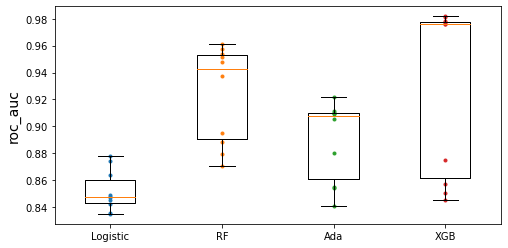

In [251]:
plt.figure(figsize=(8, 4))

i = 1

for cv_score in cv_scores:
    
    plt.plot([i]*10, cv_score, ".")
    
    i+=1
    
plt.boxplot(cv_scores, labels=("Logistic","RF","Ada","XGB"))
plt.ylabel("roc_auc", fontsize=14)
plt.show()

# 결과는 Logistic, RF, Ada, XGB알고리즘 중에 예측율이 제일 높은 RF모델 사용|